# Logit calculation benchmarking

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import configuration as config
import functions.plotting as plot_funcs

# Datasets to load
datasets={
    'logits': 'logits_calculation_benchmark.jsonl',
    #'encoding': 'encoding_memory_benchmark.json'
}

# Translation dict for column names
column_renaming_dict={
    'hf_model_string': 'Model',
    'peak_memory': 'Peak memory (GB)',
    'max_memory': 'Max memory (GB)',
    'tokens': 'Encoded length (tokens)',
    'input_length': 'Input length (words)',
    'device_map': 'Device map',
    'calculation_time': 'Logit calculation time (sec.)',
    'calculation_rate': 'Logit calculation rate (tokens per sec.)',
    'encoding_time': 'Encoding time (sec.)',
    'encoding_rate': 'Encoding rate (tokens per sec.)',
    'iteration': 'Iteration',
    'input_length_words': 'Input length (words)',
    'output_length_tokens': 'Output length (tokens)',
    'quantization': 'Quantization'

    
}

# Translation dict for string values
value_renaming_dict={
    'cuda:0': 'GTX1070',
    'cuda:1': 'Tesla K80',
    'sequential': 'Multi-GPU',
    'auto': 'Mixed GPU/CPU',
    'cpu': 'CPU only',
    'meta-llama/Meta-Llama-3-8B': 'LLaMA3-8B',
    'tiiuae/falcon-7b': 'Falcon-7B',
    'meta-llama/Llama-2-7b-hf': 'LLaMA2-7B',
    'mistralai/Mistral-7B-v0.3': 'Mistral-7B'
}

# Load and prepare datasets
datasets=plot_funcs.load_datasets(
    datasets=datasets,
    column_renaming_dict=column_renaming_dict,
    value_renaming_dict=value_renaming_dict,
    data_path=config.BENCHMARKING_DATA_PATH
)

/mnt/arkk/llm_detector_benchmarking/benchmarking


## 1. Logits calculation

### 1.1. TLDR
1. **Winner**: Speed - LLaMA2-7B on GTX1070 or multi-GPU, input length - mixed GPU/CPU (CPU alone can potential do much longer sequences but very slowly)
2. **Factor importance rank**: Device > model

In [2]:
datasets['logits'].head()

,Iteration,Model,Device map,Quantization,Input length (words),Peak memory (GB),Output length (tokens),Logit calculation time (sec.),Logit calculation rate (tokens per sec.)
0,1.0,LLaMA3-8B,GTX1070,4-bit,50,6.839152,77.0,0.785244,98.058754
1,2.0,LLaMA3-8B,GTX1070,4-bit,50,6.710237,63.0,0.160164,393.345945
2,3.0,LLaMA3-8B,GTX1070,4-bit,50,6.770242,69.0,0.200730,343.746000
3,1.0,LLaMA3-8B,GTX1070,4-bit,100,7.413712,137.0,0.698747,196.065131
4,2.0,LLaMA3-8B,GTX1070,4-bit,100,7.571732,153.0,0.343571,445.322251


### 1.2. Memory footprint, 4-bit quantization

IndexError: index 3 is out of bounds for axis 0 with size 3

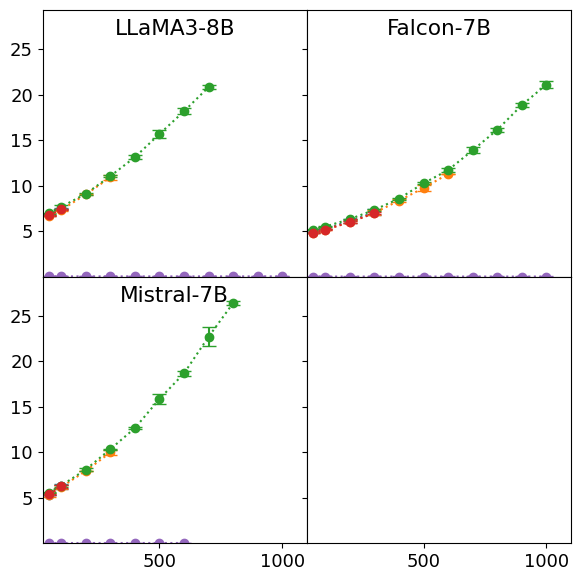

In [5]:
plot_funcs.multipanel_error_bar_two_factors(
    figure_title='Logit calculation memory footprint',
    data=datasets['logits'],
    exclusions = {'Quantization': ['8-bit']},
    panel_factor='Model',
    series_factor='Device map',
    independent_var='Input length (words)',
    dependent_var='Peak memory (GB)',
    legend_loc='center left'
).show()

1. For all devices, the memory increases almost linearly with input size up to that device's memory capacity.
2. Memory use is model dependent, with differences of 100 words or so.
3. Mixed GPU/CPU can handle the longest inputs before running out of memory (up to 1000 words or more), followed far behind by the K80 and then the GTX1070 and multi-GPU sequential tied for last with ~300 words max depending on the model

### 1.3. Logit calculation rate, 4-bit quantization

IndexError: index 3 is out of bounds for axis 0 with size 3

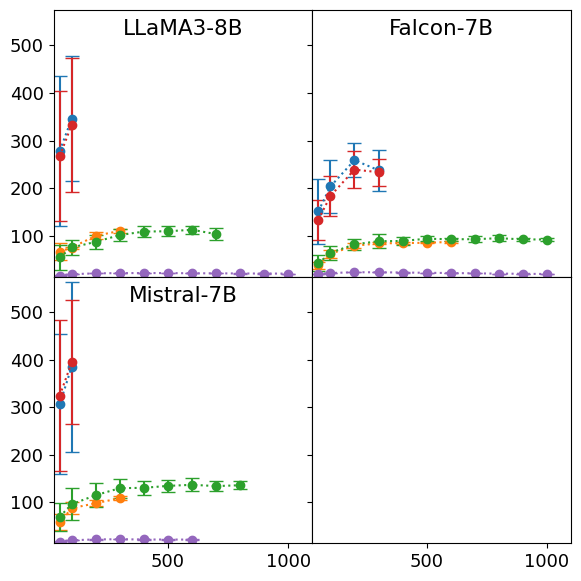

In [6]:
plot_funcs.multipanel_error_bar_two_factors(
    figure_title='GPU logit calculation rate',
    data=datasets['logits'],
    exclusions = {'Quantization': ['8-bit']},
    panel_factor='Model',
    series_factor='Device map',
    independent_var='Input length (words)',
    dependent_var='Logit calculation rate (tokens per sec.)',
    legend_loc='center right'
).show()

### 1.4 Rate and memory averages LLaMA3-8B

In [7]:
averages_df=datasets['logits'][datasets['logits']['Model'] == 'LLaMA3-8B']

averages_df.groupby(                
    ['Model', 'Device map', 'Input length (words)'],
    as_index=False
)[['Peak memory (GB)', 'Logit calculation time (sec.)']].mean()

,Model,Device map,Input length (words),Peak memory (GB),Logit calculation time (sec.)
0,LLaMA3-8B,CPU only,50,0.072635,4.498477
1,LLaMA3-8B,CPU only,100,0.072659,7.635721
2,LLaMA3-8B,CPU only,200,0.072720,13.294608
3,LLaMA3-8B,CPU only,300,0.072720,19.880755
4,LLaMA3-8B,CPU only,400,0.072788,26.491655
5,LLaMA3-8B,CPU only,500,0.072770,33.292688
6,LLaMA3-8B,CPU only,600,0.072855,40.062582
7,LLaMA3-8B,CPU only,700,0.072856,47.607652
8,LLaMA3-8B,CPU only,800,0.072720,55.076194
9,LLaMA3-8B,CPU only,900,0.072794,62.646117


1. Apparent logit calculation rate increases with longer inputs.
2. Multi-GPU sequential and the GTX1070 calculate logits at similar rates.
3. The K80 and mixed GPU/CPU calculate logits at similar rates, about half as fast as the GTX1070.
4. LLaMA2-7B is the fastest model tested at ~400 tokens per second, LLaMA3-8B and Falcon-7B are about half as fast.

### 1.4. Memory: CPU vs GPU

In [ ]:
plot_funcs.multipanel_error_bar_two_factors(
    figure_title='Logit calculation memory footprint',
    data=datasets['logits_cpu'],
    y_axis_extra_pad=3,
    panel_factor='Model',
    series_factor='Device map',
    independent_var='Input length (words)',
    dependent_var='Max memory (GB)',
    legend_loc='center right'
).show()

1. CPU memory use does not change with increasing input length, up to 1000 words, but depends on the model. Mistral-7B uses the most with just under 40 GB and LLaMA3-8B uses the least with around 10 GB.
2. GPU memory use is model dependent, Falcon-7B can handle the longest input sequences, followed by LLaMA2-7B and then LLaMA3-8B and Mistral-7B tie for last place.

### 1.5. Rate: CPU vs GPU

In [ ]:
plot_funcs.multipanel_error_bar_two_factors(
    figure_title='Logit calculation rate',
    data=datasets['logits_cpu'],
    y_axis_extra_pad=10,
    panel_factor='Model',
    series_factor='Device map',
    independent_var='Input length (words)',
    dependent_var='Logit calculation rate (tokens per sec.)',
    legend_loc='center right'
).show()

1. CPU is much, much slower than GPU but can calculate logits for extremely long sequences without significant slowdown.
2. GPU logit calculation rate increases with longer input sequences.
3. On GPU, LLaMA2-7B is fastest, LLaMA3-8B, Falcon-7B, and Mistral-7B are slower by 50-60%.

### 1.6. Conclusions

1. Fastest logit calculation is with LLaMA2-7B on the GTX1070 or multi-GPU sequential.
2. The best trade-off between speed and input length is mixed GPU/CPU.
3. CPU can calculate logits for very long sequences, at the cost of low speed.

## 2. String encoding

### 2.1. TLDR
Encoding is very fast compared to logit calculation, and the apparent speed only increases with longer inputs. Memory use is basically flat - we can basically disregard this step for optimization purposes.

### 2.2. Plot: memory footprint for device map & input sequence length

In [ ]:
plot_funcs.single_errorbar(
    figure_title='Encoding memory footprint',
    data=datasets['encoding'],
    series_factor='Device map',
    independent_var='Input length (words)',
    dependent_var='Peak memory (GB)'
).show()

### 2.3. Plot: encoding rate for device map & input sequence length

In [ ]:
# Change units for plotting
datasets['encoding']['Encoding rate (tokens per millisec.)']=datasets['encoding']['Encoding rate (tokens per sec.)'] / 1000

plot_funcs.single_errorbar(
    figure_title='Encoding rate',
    data=datasets['encoding'],
    series_factor='Device map',
    independent_var='Input length (words)',
    dependent_var='Encoding rate (tokens per millisec.)'
).show()